In [1]:
import os
import numpy as np 
import logging

import tensorflow as tf 
from tensorflow import keras 
from tensorflow.keras import layers 

import nibabel as nib 
from scipy import ndimage

In [2]:
print("Num GPUs Available: ", len(tf.config.list_physical_devices('GPU')))
tf.debugging.set_log_device_placement(False)
# tf.get_logger().setLevel('ERROR')

Num GPUs Available:  1


In [3]:
def read_nifti_file(filepath):
    """Read and load volume"""
    # Load file
    scan = nib.load(filepath)
    # Get raw data
    scan = scan.get_fdata()
    return scan

def normalize(volume):
    """normalize the volume""" 
    min = -1000
    max = 400
    volume[ volume < min ] = min 
    volume[ volume > max ] = max
    volume = (volume - min)/(max - min)
    volume = volume.astype("float32")
    return volume


def resize_volume(img):
    """Resize across z-axis"""
    # Set desired depth
    desired_depth = 64
    desired_width = 128 
    desired_height = 128 
    # Get current depth 
    current_depth = img.shape[-1]
    current_width = img.shape[0]
    current_height = img.shape[1]
    # Compute Depth factor
    depth = current_depth/desired_depth
    width = current_width/desired_width
    height = current_height/desired_height

    depth_factor = 1/depth 
    width_factor = 1/width 
    height_factor = 1/height 

    # Rotate
    img = ndimage.rotate(img, 90, reshape = False)

    # Resize across z-axis 
    img = ndimage.zoom(img, (width_factor, height_factor, depth_factor), order = 1)

    return img 




def process_scan(path):
    """ Read and resize volume"""
    # Read scan 
    volume = read_nifti_file(path)

    volume = normalize(volume)
    volume = resize_volume(volume)
    return volume




In [4]:
normal_scans_path = [
    os.path.join(os.getcwd(), "MosMedData/CT-0", x)
    for x in os.listdir("MosMedData/CT-0")
]

abnormal_scans_path = [
    os.path.join(os.getcwd(),"MosMedData/CT-23",x)
    for x in os.listdir("MosMedData/CT-23")
]

print("CT scans with normal lung tissue: " + str(len(normal_scans_path)))
print("CT scans with abnormal lung tissue: " + str(len(abnormal_scans_path)))

CT scans with normal lung tissue: 100
CT scans with abnormal lung tissue: 100


In [5]:
# Train and Validation steps

abnormal_scans = np.array([process_scan(path) for path in abnormal_scans_path])
normal_scans = np.array([process_scan(path) for path in normal_scans_path])

abnormal_labels = np.array([1 for _ in range (len(abnormal_scans))])
normal_labels = np.array([0 for _ in range(len(normal_scans))])


x_train = np.concatenate((abnormal_scans[:70], normal_scans[:70]), axis=0)
y_train = np.concatenate((abnormal_labels[:70], normal_labels[:70]), axis=0)
x_val = np.concatenate((abnormal_scans[70:], normal_scans[70:]), axis=0)
y_val = np.concatenate((abnormal_labels[70:], normal_labels[70:]), axis=0)

print(
    "Number of samples in train and validation are %d and %d."
    % (x_train.shape[0], x_val.shape[0])
)

Number of samples in train and validation are 140 and 60.


In [6]:
import random
from scipy import ndimage

@tf.function
def rotate(volume):
    """Rotate the volume by a few degrees"""
    def scipy_rotate(volume):
        angles = [-20,-10, -5, 5, 10 , 20]
        angle = random.choice(angles)

        volume = ndimage.rotate(volume,angle,reshape=False)
        volume[volume<0] = 0
        volume[volume>1] = 1
        return volume

    augmented_volume = tf.numpy_function(scipy_rotate, [volume], tf.float32)
    return augmented_volume

def train_preprocessing(volume, label):
    """Rotate and add channels to date"""
    volume = rotate(volume)
    volume = tf.expand_dims(volume, axis = 3)
    return volume, label 

def validation_preprocessing(volume, label):
    volume = tf.expand_dims(volume, axis=3)
    return volume, label



In [7]:
# Define Data Loaders 

train_loader = tf.data.Dataset.from_tensor_slices((x_train, y_train))
validation_loader = tf.data.Dataset.from_tensor_slices((x_val, y_val))

batch_size = 2 

train_dataset = (
    train_loader.shuffle(len(x_train))
    .map(train_preprocessing)
    .batch(batch_size)
    .prefetch(2)
)

validation_dataset = (
    validation_loader.shuffle(len(x_val))
    .map(validation_preprocessing)
    .batch(batch_size)
    .prefetch(2)
)



Dimension of the CT scan is: (128, 128, 64, 1)


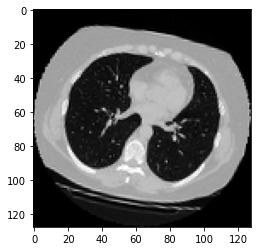

In [8]:
import matplotlib.pyplot as plt 

data = train_dataset.take(1)
images, labels = list(data)[0]

images = images.numpy()
image = images[0]
print("Dimension of the CT scan is:", image.shape)
plt.imshow(np.squeeze(image[:,:,30]), cmap="gray")

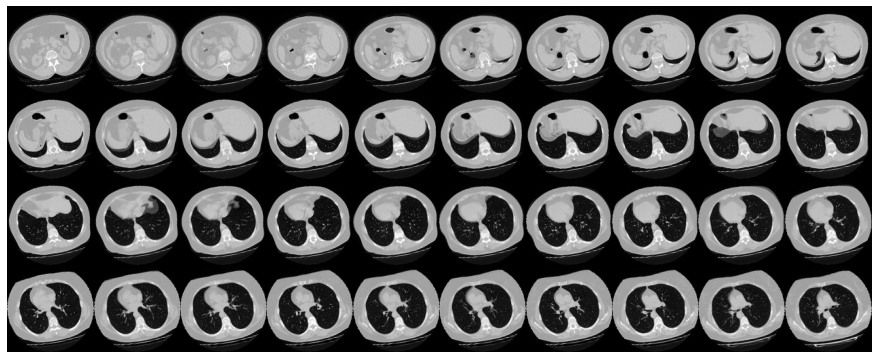

In [9]:
def plot_slices(num_rows, num_columns, width, height, data):
    """Plot a montage of 20 CT slicemails"""
    data = np.rot90(np.array(data))
    data = np.transpose(data)
    data = np.reshape(data, (num_rows, num_columns, width, height))
    rows_data, columns_data = data.shape[0], data.shape[1]
    heights = [slc[0].shape[0] for slc in data]
    widths = [slc.shape[1] for slc in data[0]]
    fig_width = 12.0
    fig_height = fig_width * sum(heights) / sum(widths)
    f, axarr = plt.subplots(
        rows_data,
        columns_data,
        figsize=(fig_width, fig_height),
        gridspec_kw={"height_ratios": heights},
    )
    for i in range(rows_data):
        for j in range(columns_data):
            axarr[i, j].imshow(data[i][j], cmap="gray")
            axarr[i, j].axis("off")
    plt.subplots_adjust(wspace=0, hspace=0, left=0, right=1, bottom=0, top=1)
    plt.show()


# Visualize montage of slices.
# 4 rows and 10 columns for 100 slices of the CT scan.
plot_slices(4, 10, 128, 128, image[:, :, :40])

In [10]:
def get_model(width=128, height =128, depth = 64):
    """Build 3D conv model"""

    inputs = keras.Input((width, height, depth, 1))

    x = layers.Conv3D(filters = 32, kernel_size=3, activation="relu")(inputs)
    x = layers.MaxPool3D(pool_size = 2)(x)
    x = layers.BatchNormalization()(x)

    x = layers.Conv3D(filters = 32, kernel_size=3, activation="relu")(x)
    x = layers.MaxPool3D(pool_size = 2)(x)
    x = layers.BatchNormalization()(x)

    # x = layers.Conv3D(filters = 64, kernel_size=3, activation="relu")(x)
    # x = layers.MaxPool3D(pool_size = 2)(x)
    # x = layers.BatchNormalization()(x)

    # x = layers.Conv3D(filters = 64, kernel_size=3, activation="relu")(x)
    # x = layers.MaxPool3D(pool_size = 2)(x)
    # x = layers.BatchNormalization()(x)

    x = layers.GlobalAveragePooling3D()(x)
    x = layers.Dense(units=256, activation="relu")(x)
    x = layers.Dropout(0.3)(x)

    outputs = layers.Dense(units=1, activation="sigmoid")(x)


    model = keras.Model(inputs, outputs, name="3Dcnn")
    return model 

# Build Model
model = get_model(width=128, height =128, depth = 64)
model.summary()

Model: "3Dcnn"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 128, 128, 64, 1)] 0         
_________________________________________________________________
conv3d (Conv3D)              (None, 126, 126, 62, 32)  896       
_________________________________________________________________
max_pooling3d (MaxPooling3D) (None, 63, 63, 31, 32)    0         
_________________________________________________________________
batch_normalization (BatchNo (None, 63, 63, 31, 32)    128       
_________________________________________________________________
conv3d_1 (Conv3D)            (None, 61, 61, 29, 32)    27680     
_________________________________________________________________
max_pooling3d_1 (MaxPooling3 (None, 30, 30, 14, 32)    0         
_________________________________________________________________
batch_normalization_1 (Batch (None, 30, 30, 14, 32)    128   

In [11]:
# print("Num GPUs Available: ", len(tf.config.list_physical_devices('GPU')))
# tf.debugging.set_log_device_placement(True)

In [15]:
# Compile Model

initial_learning_rate = 0.001
lr_schedule = keras.optimizers.schedules.ExponentialDecay(
    initial_learning_rate, decay_steps=100000, decay_rate = 0.96, staircase = True
)

model.compile(
    loss = "binary_crossentropy",
    optimizer = keras.optimizers.Adam(learning_rate=lr_schedule),
    metrics = ["acc"]
)

#Define Callbacks 
checkpoint_cb = keras.callbacks.ModelCheckpoint(
    "3D_image_classification.h5", save_best_only = True
)

early_stopping_cb = keras.callbacks.EarlyStopping(monitor="acc", patience=5)

epochs = 50
model.fit(
    train_dataset,
    validation_data = validation_dataset,
    epochs = epochs,
    shuffle = True,
    verbose = 2,
    callbacks = [checkpoint_cb, early_stopping_cb]
)

Epoch 1/50
70/70 - 15s - loss: 0.6806 - acc: 0.5714 - val_loss: 0.6946 - val_acc: 0.5000
Epoch 2/50
70/70 - 15s - loss: 0.6787 - acc: 0.6357 - val_loss: 0.6774 - val_acc: 0.5333
Epoch 3/50
70/70 - 15s - loss: 0.6849 - acc: 0.5500 - val_loss: 0.6598 - val_acc: 0.6333
Epoch 4/50
70/70 - 14s - loss: 0.6768 - acc: 0.5857 - val_loss: 0.6920 - val_acc: 0.5000
Epoch 5/50
70/70 - 14s - loss: 0.6703 - acc: 0.5857 - val_loss: 0.6938 - val_acc: 0.5000
Epoch 6/50
70/70 - 14s - loss: 0.6618 - acc: 0.6500 - val_loss: 0.6494 - val_acc: 0.6000
Epoch 7/50
70/70 - 15s - loss: 0.6544 - acc: 0.6286 - val_loss: 0.6434 - val_acc: 0.6167
Epoch 8/50
70/70 - 15s - loss: 0.6536 - acc: 0.6429 - val_loss: 0.6094 - val_acc: 0.6500
Epoch 9/50
70/70 - 15s - loss: 0.6902 - acc: 0.5429 - val_loss: 0.6134 - val_acc: 0.6500
Epoch 10/50
70/70 - 15s - loss: 0.6732 - acc: 0.6214 - val_loss: 2.2438 - val_acc: 0.5000
Epoch 11/50
70/70 - 15s - loss: 0.6797 - acc: 0.5786 - val_loss: 0.7204 - val_acc: 0.5167


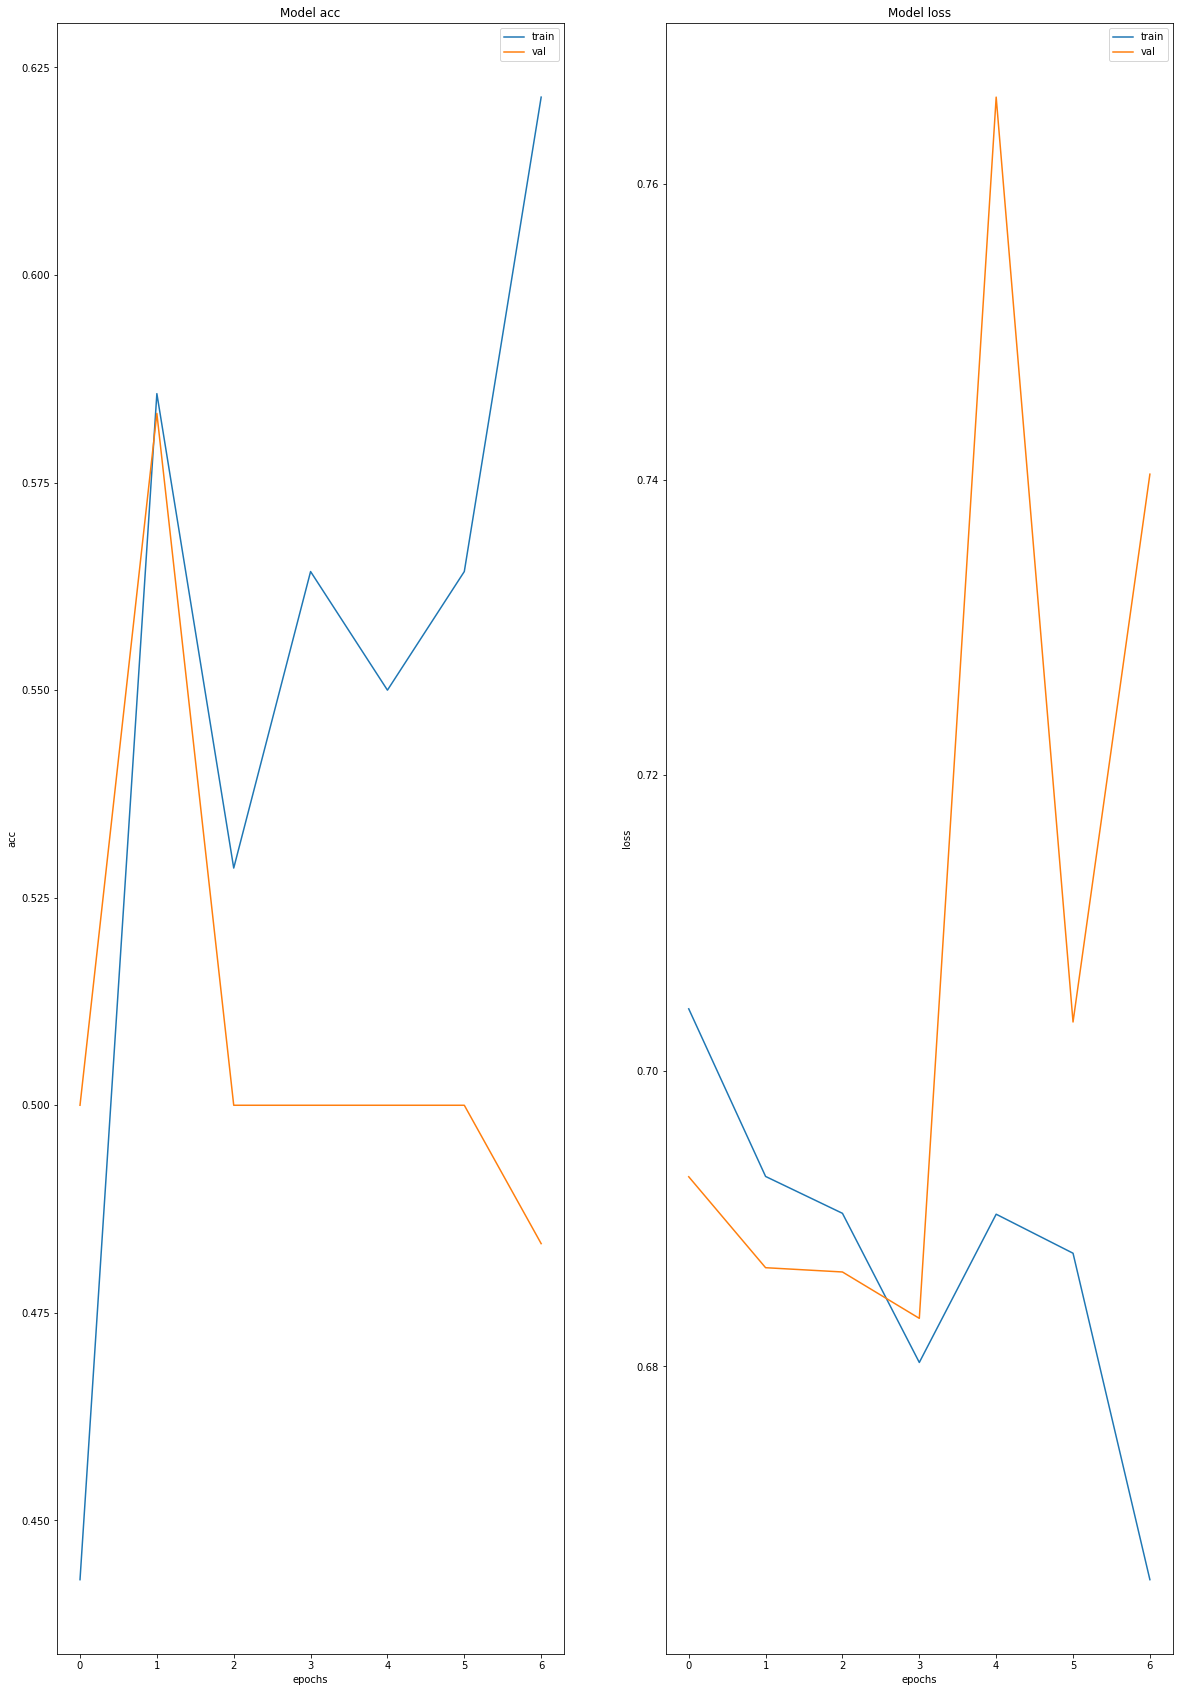

In [13]:
# Viz Data 

fig, ax = plt.subplots(1,2,figsize=(20,30))
ax = ax.ravel()

for i, metric in enumerate(["acc", "loss"]):
    ax[i].plot(model.history.history[metric])
    ax[i].plot(model.history.history["val_" + metric])
    ax[i].set_title("Model {}".format(metric))
    ax[i].set_xlabel("epochs")
    ax[i].set_ylabel(metric)
    ax[i].legend(["train", "val"])


In [14]:
# Load best weights.
model.load_weights("3d_image_classification.h5")
prediction = model.predict(np.expand_dims(x_val[0], axis=0))[0]
scores = [1 - prediction[0], prediction[0]]

class_names = ["normal", "abnormal"]
for score, name in zip(scores, class_names):
    print(
        "This model is %.2f percent confident that CT scan is %s"
        % ((100 * score), name)
    )

This model is 54.45 percent confident that CT scan is normal
This model is 45.55 percent confident that CT scan is abnormal
